In [134]:
import os
import glob

import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns


import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [135]:
os.chdir('C:/Users/Olsen/Desktop/Masteroppgave/Code/Swell/')

# new_model = tf.keras.models.load_model('forTransferL.h5')
# #model.layers[0].trainable = False
# #x = model.layers[10].output
# new_model.summary()

# Load the pre-trained model
pretrained_model = load_model('forTransferL_swell.h5')

# Display the summary of the pre-trained model
pretrained_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 34)                306       
                                                                 
 dense_2 (Dense)             (None, 64)                2240      
                                                                 
 dense_3 (Dense)             (None, 36)                2340      
                                                                 
 dense_4 (Dense)             (None, 12)                444       
                                                                 
 dense_5 (Dense)             (None, 9)                 117       
                                                                 
 dense_6 (Dense)             (None, 2)                 2

In [136]:
# date,timestamp,hrv,dfa,sport,feeling,rpe

# def replace_feeling(value):
#     if value >= 6:
#         return 'good'
#     elif value == 5:
#         return 'okay'
#     else:
#         return 'bad'


def replace_feeling(value):
    if value >= 5:
        return 1
    else:
        return 2


# Function to load and preprocess data from a single file
def load_and_preprocess(file_path, session):
    # df = pd.read_csv(file_path, sep=',', 
    #              parse_dates={'dt' : ['date', 'timestamp']}, infer_datetime_format=True, 
    #              low_memory=False, na_values=['nan','?'], index_col='dt')
    df = pd.read_csv(file_path, sep=',')

    droping_list_all=[]

    df = df.drop(columns=['sport', 'date'])
    for j in range(0,len(df.columns)):
        if not df.iloc[:, j].notnull().all():
            droping_list_all.append(j)        
            #print(df.iloc[:,j].unique())
    
    # filling nan with mean in any columns

    for j in range(0,len(df.columns)):        
            df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
    # another sanity check to make sure that there are not more any nan
    df.isnull().sum()



    # Add a new column to the DataFrame
    session_numbers = [session]*len(df['hrv'])  # Example values for the new column
    df['session'] = session_numbers
    # df2 = pd.DataFrame({"session": [session]*len(df['hrv'])})
    # df = df.append(df2, ignore_index = True)

    # for f in df['feeling']:
    #     if f >= 5:
    #         df['feeling'][f] = 1
    #     else:
    #         df['feeling'][f] = 2
    # df.feeling[df.feeling == 9] = 2
    # df.feeling[df.feeling == 7] = 2
    # df.feeling[df.feeling == 5] = 2
    # df.feeling[df.feeling == 3] = 1
    #df.feeling[df.feeling == 1] = 1
    # Applying the function to the 'feeling' column
    df['feeling'] = df['feeling'].apply(lambda x: replace_feeling(x))

    # print(df.dtypes)
    # print(df.shape)
    # print(df.describe())


    X = df[['session','timestamp', 'hrv', 'dfa']]
    y = df['feeling']

    # scaler = MinMaxScaler()
    # X = scaler.fit_transform(X)
    return X, y

# Function to load and preprocess data from multiple files in a folder
def load_data_from_folder(folder_path):
    X_all, y_all = [], []

    session = 1

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            X, y = load_and_preprocess(file_path, session)
            X_all.append(X)
            y_all.append(y)
            session += 1


    X_all = np.vstack(X_all)
    y_all = np.concatenate(y_all)

    return X_all, y_all


In [137]:
def features_calc(file_list):
    # List to store results
    hrv_mean_list = []
    dfa_mean_list = []
    sport_list = []
    date_list = []
    feeling_list = []
    rpe_list = []
    dropping_list_all = []
    rmssd_list = []
    mean_rr_list = []
    sdnn_list = []
    mean_hr_list = []
    std_hr_list = []
    min_hr_list = []
    max_hr_list = []
    nnxx_list = []
    pnnx_list = []
    sdrr_list = []
    sdsd_list = []
    sdrr_rmssd_list = []
    hr_list = []
    pnn25_list = []
    pnn50_list = []

    # Loop through each file in the directory
    for file in file_list:
        # Read data from the file
        data = pd.read_csv(file)
        
        # sport = data['sport'][0]
        # date = data['date'][0]
        # feeling = data['feeling'][0]
        # rpe = data['rpe'][0]
        # sport_list.append(sport)
        # date_list.append(date)
        # feeling_list.append(int(feeling))
        # rpe_list.append(rpe)

        data = data.drop(columns=['sport', 'date'])
        for j in range(0,len(data.columns)):
            if not data.iloc[:, j].notnull().all():
                dropping_list_all.append(j)        
            
            # filling nan with mean in any columns

        for j in range(0,len(data.columns)):
            data.iloc[:,j]=data.iloc[:,j].fillna(data.iloc[:,j].mean())
        # another sanity check to make sure that there are not more any nan
        data.isnull().sum()


        # chunk = len(data)-1
        chunk = 30
        for i in range(chunk, len(data), chunk):
            # sport = data['sport'][i]
            # date = data['date'][i]
            feeling = data['feeling'][i]
            rpe = data['rpe'][i]
            # sport_list.append(sport)
            # date_list.append(date)
            feeling_list.append(int(feeling))
            rpe_list.append(rpe)

            hrv_mean = np.mean(data['hrv'][i-chunk:i])
            dfa_mean = np.mean(data['dfa'][i-chunk:i])

            rr = (60/data['hrv'][i-chunk:i])*1000
            # RMSSD: take the square root of the mean square of the differences
            rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
            # Mean RR
            mean_rr = np.mean(rr)
            # SDNN
            sdnn = np.std(rr)
            # Mean HR
            mean_hr = 60 * 1000/np.mean(rr)
            # STD HR
            std_hr = np.std(data['hrv'][i-chunk:i])
            # Min HR
            min_hr = np.min(data['hrv'][i-chunk:i])
            # Max HR
            max_hr = np.max(data['hrv'][i-chunk:i])
            # NNxx: sum absolute differences that are larger than 50ms
            nnxx = np.sum(np.abs(np.diff(rr)) > 50)*1
            # pNNx: fraction of nnxx of all rr-intervals
            pnnx = 100 * nnxx / len(rr)
            # SDRR: Standard Deviation of RR intervals
            sdrr = np.std(rr)
            # SDSD: Standard Deviation of successive differences
            sdsd = np.std(np.diff(rr))
            # SDRR_RMSSD: ratio of SDRR to RMSSD
            sdrr_rmssd = sdrr / rmssd if rmssd != 0 else 0
            # pNN25: percentage of successive RR intervals differing by more than 25 ms
            pnn25 = 100 * np.sum(np.abs(np.diff(rr)) > 25) / len(rr)
            # pNN50: percentage of successive RR intervals differing by more than 50 ms
            pnn50 = 100 * np.sum(np.abs(np.diff(rr)) > 50) / len(rr)


            hrv_mean_list.append(hrv_mean)
            dfa_mean_list.append(dfa_mean)

            rmssd_list.append(rmssd)
            mean_rr_list.append(mean_rr)
            sdnn_list.append(sdnn)
            std_hr_list.append(std_hr)
            min_hr_list.append(min_hr)
            max_hr_list.append(max_hr)
            nnxx_list.append(nnxx)
            pnnx_list.append(pnnx)
            sdrr_list.append(sdrr)
            sdsd_list.append(sdsd)
            sdrr_rmssd_list.append(sdrr_rmssd)
            pnn25_list.append(pnn25)
            pnn50_list.append(pnn50)

    df_mean = pd.DataFrame({
        # 'date': date_list,
        # 'sport': sport_list,
        'HR': hrv_mean_list,
        'dfa': dfa_mean_list,
        'RMSSD': rmssd_list,
        'MEAN_RR': mean_rr_list,
        'SDNN': sdnn_list,
        'STD': std_hr_list,
        'min hr': min_hr_list,
        'max hr': max_hr_list,
        'nnxx': nnxx_list,
        'pnnx': pnnx_list,
        'SDRR': sdrr_list,
        'SDSD': sdsd_list,
        'SDRR_RMSSD': sdrr_rmssd_list,
        'pNN25': pnn25_list,
        'pNN50': pnn50_list,
        'feeling': feeling_list,
        'rpe': rpe_list,
    })

    df_mean['feeling'] = df_mean['feeling'].apply(lambda x: replace_feeling(x))
    return df_mean

In [138]:
# # Specify the folder containing your CSV files
# train_folder = "C:/Users/Olsen/Desktop/Masteroppgave/Data/fitfiler/candidate2/csv_files"

# # Load and preprocess data from multiple files in the folder
# X_train, y_train = load_data_from_folder(train_folder)


# # Specify the folder containing your CSV files
# test_folder = "C:/Users/Olsen/Desktop/Masteroppgave/Data/fitfiler/candidate1/csv_files"

# # Load and preprocess data from multiple files in the folder
# X_test, y_test = load_data_from_folder(test_folder)

# print(X_train)
# # print(X_test)

# # Split the data into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)



# # Reshape input data for LSTM
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# print(X_train.shape)

In [139]:
os.chdir('C:/Users/Olsen/Desktop/Masteroppgave/Data/fitfiler/candidate2/csv_files')

files = glob.glob('*.csv')  # Adjust the path as needed

# files_train, files_test = train_test_split(files, test_size=0.15)
files_train, files_test = train_test_split(files, test_size=0.2, random_state=42)

df_mean_train_can2 = features_calc(files_train)
df_mean_test_can2 = features_calc(files_test)



os.chdir('C:/Users/Olsen/Desktop/Masteroppgave/Data/fitfiler/candidate1/csv_files')

files = glob.glob('*.csv')  # Adjust the path as needed
# files_train, files_test = train_test_split(files, test_size=0.15)
files_train, files_test = train_test_split(files, test_size=0.2, random_state=42)

df_mean_train_can1 = features_calc(files_train)
df_mean_test_can1 = features_calc(files_test)




frames_test = [df_mean_test_can1, df_mean_test_can2]
df_mean_test = pd.concat(frames_test, ignore_index=True)

frames_train = [df_mean_train_can1, df_mean_train_can2]
df_mean_train = pd.concat(frames_train, ignore_index=True)

# MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,SD2,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
# X_train = df_mean_train[['dfa', 'hrv', 'rmssd', 'mean rr', 'sdrr', 'sdsd', 'sdrr_rmssd', 'pnn25','pnn50']]
X_train = df_mean_train[['MEAN_RR', 'SDRR', 'RMSSD','SDSD', 'SDRR_RMSSD','HR', 'pNN25','pNN50']]
# y_train = df_mean_train['feeling']

print(X_train.shape)


# MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,SD2,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,LF_HF,HF_LF,sampen,higuci,datasetId,condition
# X_test = df_mean_test[['mean rr', 'sdrr', 'rmssd','sdsd', 'sdrr_rmssd','hrv', 'pnn25','pnn50']]
X_test = df_mean_test[['MEAN_RR', 'SDRR', 'RMSSD','SDSD', 'SDRR_RMSSD','HR', 'pNN25','pNN50']]
# y_test = df_mean_test['feeling']

print(X_test.shape)

df_mean_train.columns

(38547, 8)
(9276, 8)


Index(['HR', 'dfa', 'RMSSD', 'MEAN_RR', 'SDNN', 'STD', 'min hr', 'max hr',
       'nnxx', 'pnnx', 'SDRR', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50',
       'feeling', 'rpe'],
      dtype='object')

In [140]:
y_train = df_mean_train['feeling']


y_train = pd.get_dummies(df_mean_train['feeling'])

# y_train = df_mean_train['feeling']
# labelencoder = LabelEncoder()
# y_train = labelencoder.fit_transform(df_mean_train["feeling"])

y_train

,1,2
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
38542,1,0
38543,1,0
38544,1,0
38545,1,0


In [141]:
y_test = df_mean_test['feeling']


y_test = pd.get_dummies(df_mean_test['feeling'])

# y_test = df_mean_test['feeling']
# labelencoder = LabelEncoder()
# y_test = labelencoder.fit_transform(df_mean_test["feeling"])

y_test


,1,2
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
9271,1,0
9272,1,0
9273,1,0
9274,1,0


In [142]:
# Display the summary of the pre-trained model
pretrained_model.summary()

input_shape = (8,)

# Create a new model for transfer learning
transfer_model = Sequential()

# transfer_model.add(Dense(8, activation='sigmoid', input_shape=input_shape, name='dense_input'))

for layer in pretrained_model.layers[:-1]:
    transfer_model.add(layer)


# transfer_model.add(Dense(1, activation='sigmoid', name='output_layer'))  # Modify activation based on your problem


# for layer in pretrained_model.layers[:-2]:
#     layer.trainable = True

# transfer_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
transfer_model.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

transfer_model.summary()

# transfer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

pretrained_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.1, shuffle=True)
# transfer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# transfer_model.save('transfer_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 34)                306       
                                                                 
 dense_2 (Dense)             (None, 64)                2240      
                                                                 
 dense_3 (Dense)             (None, 36)                2340      
                                                                 
 dense_4 (Dense)             (None, 12)                444       
                                                                 
 dense_5 (Dense)             (None, 9)                 117       
                                                                 
 dense_6 (Dense)             (None, 2)                 2

In [143]:
# # Create a new model for transfer learning
# transfer_model = Sequential()

# # Add a Flatten layer to reshape the input
# # transfer_model.add(Flatten(input_shape=(1, 9)))


# # Add layers to the transfer model by iterating through the pre-trained model layers
# for layer in pretrained_model.layers[:-1]:
#     # Add a layer with the same configuration, excluding the input shape
#     transfer_model.add(layer.__class__.from_config(layer.get_config()))

# # Add a new output layer with the correct number of units for your specific problem
# transfer_model.add(Dense(1, activation='sigmoid'))  # Modify activation based on your problem


# # Compile the transfer model
# transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Display the summary of the transfer model
# transfer_model.summary()

# # Assuming your training data is stored in X_train and labels in y_train
# # Make sure to adjust the parameters in fit() according to your requirements
# transfer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



In [145]:
test_loss, test_acc = pretrained_model.evaluate(X_test,  y_test, verbose=2)
print('\nTest loss: ', test_loss)
print('\nTest accuracy: ', test_acc)


290/290 - 1s - loss: 17.6845 - accuracy: 0.5040 - 772ms/epoch - 3ms/step

Test loss:  17.684499740600586

Test accuracy:  0.5039888024330139


## Predictions

### Squential

In [146]:


# Make predictions
probability_model = tf.keras.Sequential([transfer_model, tf.keras.layers.Softmax()])
y_predict = probability_model.predict(X_test)
# predictions = model.predict(X_test)

print(y_predict)
y_pred = np.argmax(y_predict, axis = -1)

t =pd.DataFrame(y_test)
t.value_counts()
df_mean_test.feeling.value_counts()


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred, zero_division=np.nan)
print("Classification Report:")
print(report)

confusion = confusion_matrix(y_test, y_pred, normalize='pred') # add normalize='pred' if want %
print('Confusion Matrix\n')
print(confusion)

ax = sns.heatmap(confusion, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

290/290 [==============================] - 1s 3ms/step
[[0.26894143 0.73105854]
 [0.26894143 0.73105854]
 [0.26894143 0.73105854]
 ...
 [0.26894143 0.73105854]
 [0.26894143 0.73105854]
 [0.26894143 0.73105854]]


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

### Random Forest Classifier

Accuracy: 0.5458171625700733
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      4606
           1       0.55      0.51      0.53      4670

    accuracy                           0.55      9276
   macro avg       0.55      0.55      0.55      9276
weighted avg       0.55      0.55      0.55      9276



Text(50.722222222222214, 0.5, 'Actual Values ')

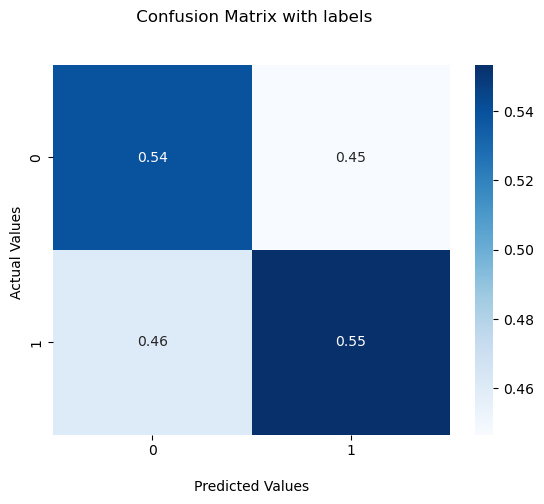

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=1, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

result = confusion_matrix(y_test, y_pred, normalize='pred')

ax = sns.heatmap(result, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')



# result = confusion_matrix(y_test, y_pred , normalize='pred')
# print(classification_report(y_test, y_pred))

# disp = ConfusionMatrixDisplay(confusion_matrix=result)

# disp.plot(cmap=plt.cm.Blues)
# plt.show()

In [ ]:

# Evaluate the model
loss = transfer_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

test_loss, test_acc = transfer_model.evaluate(X_test,  y_test, verbose=2)
print('\nTest loss: ', test_loss)
print('\nTest accuracy: ', test_acc)


290/290 [==============================] - 0s 1ms/step - loss: 0.5050 - accuracy: 0.4963
Test Loss: [0.5049693584442139, 0.49633461236953735]
290/290 - 0s - loss: 0.5050 - accuracy: 0.4963 - 432ms/epoch - 1ms/step

Test loss:  0.5049693584442139

Test accuracy:  0.49633461236953735


### Decision Tree Classifier

Accuracy: 0.5458171625700733
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      4606
           1       0.55      0.51      0.53      4670

    accuracy                           0.55      9276
   macro avg       0.55      0.55      0.55      9276
weighted avg       0.55      0.55      0.55      9276

              precision    recall  f1-score   support

           0       0.54      0.58      0.56      4606
           1       0.55      0.51      0.53      4670

    accuracy                           0.55      9276
   macro avg       0.55      0.55      0.55      9276
weighted avg       0.55      0.55      0.55      9276



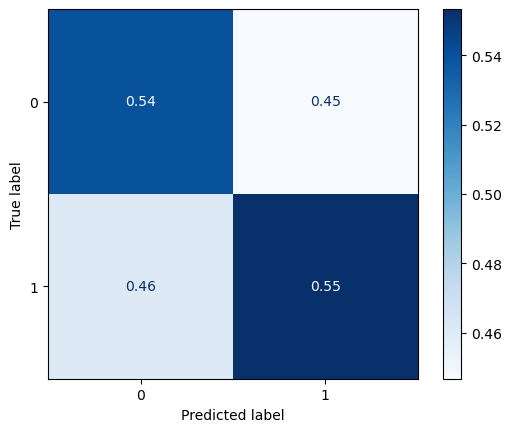

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


result = confusion_matrix(y_test, y_pred, normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### K Nearest Neighbors Classifier

Accuracy: 0.5458171625700733
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      4606
           1       0.55      0.51      0.53      4670

    accuracy                           0.55      9276
   macro avg       0.55      0.55      0.55      9276
weighted avg       0.55      0.55      0.55      9276

              precision    recall  f1-score   support

           0       0.54      0.58      0.56      4606
           1       0.55      0.51      0.53      4670

    accuracy                           0.55      9276
   macro avg       0.55      0.55      0.55      9276
weighted avg       0.55      0.55      0.55      9276



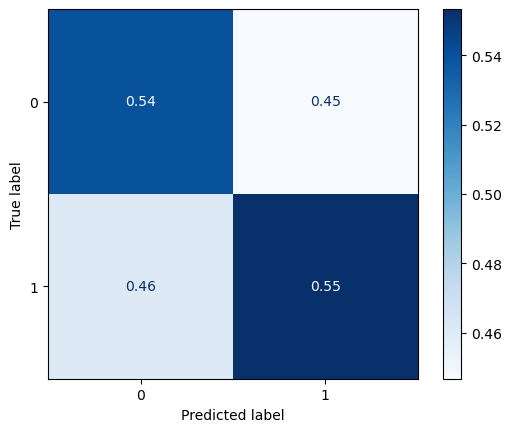

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=1000)
knn_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


result = confusion_matrix(y_test, y_pred, normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Gradient Boosting Classifier

Accuracy: 0.5458171625700733
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      4606
           1       0.55      0.51      0.53      4670

    accuracy                           0.55      9276
   macro avg       0.55      0.55      0.55      9276
weighted avg       0.55      0.55      0.55      9276



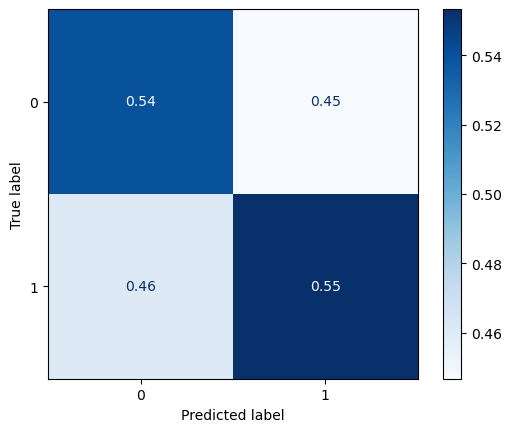

In [ ]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


result = confusion_matrix(y_test, y_pred, normalize='pred')


disp = ConfusionMatrixDisplay(confusion_matrix=result)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# model.save('forTransferL.h5')